# Defining and experimenting with FRET values

In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


In [2]:
#My image
file_path = '../Dropbox Files/hel1.pma'
image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# Poly Mapping
CH1_peaks_10 = np.array([[55,63], [14, 194], [179, 45], [115, 172], [273, 65], [257, 192], [358, 91], [365, 199], [419, 44], [445, 205]])
CH2_peaks_10 = np.array([[60, 322], [18, 453], [183, 304], [119, 431], [276, 323], [258, 450], [359, 350], [364, 456], [420, 301], [446, 462]])

params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_pairs(good_peaks_1, mapped_peaks_10, tolerance=4)

# This code is substituted for plot_circle(image, 4, y_centre, x_centre, image.shape[0])
circle_array_CH1 = draw_circle(4, poly_pair_arr_CH1_tol4_10[:,1], poly_pair_arr_CH1_tol4_10[:,0], image.shape[0])
circle_array_CH2 = draw_circle(4, poly_pair_arr_CH2_tol4_10[:,1], poly_pair_arr_CH2_tol4_10[:,0], image.shape[0])
circle_array_new = circle_array_CH1 + circle_array_CH2
mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]


In [3]:
# def FRET(I_D_list, I_A_list):
#     I_D, I_A = np.array(I_D_list), np.array(I_A_list)
#     FRET_arr = I_A/(I_D + I_A)
#     return FRET_arr.tolist()

In [4]:
#select a pair of peaks!
pair0_CH1 = poly_pair_arr_CH1_tol4_10[0]
pair0_CH2 = poly_pair_arr_CH2_tol4_10[0]
print(f"Pair 0 CH1: {pair0_CH1} \nPair 0 CH2: {pair0_CH2}")

Pair 0 CH1: [493 131] 
Pair 0 CH2: [495 390]


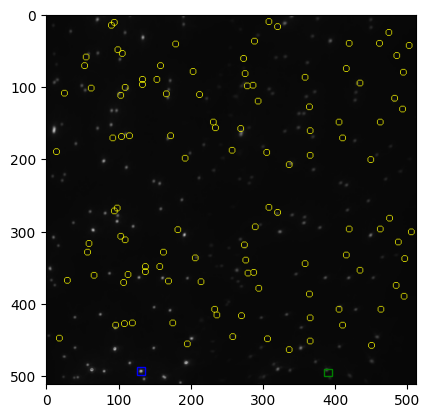

In [5]:
# def coorinates
y, x = pair0_CH2
y_CH1, x_CH1 = pair0_CH1
x1, x2 = max(0, x - 5), min(image_3d.shape[1], x + 5)
y1, y2 = max(0, y - 5), min(image_3d.shape[0], y + 5)
x1_CH1, x2_CH1 = max(0, x_CH1 - 5), min(image_3d.shape[1], x_CH1 + 5)
y1_CH1, y2_CH1 = max(0, y_CH1 - 5), min(image_3d.shape[0], y_CH1 + 5)

fig, ax = plt.subplots()
ax.imshow(image_3d)
rect2 = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect2)
rect1 = patches.Rectangle((x1_CH1, y1_CH1), x2_CH1 - x1_CH1, y2_CH1 - y1_CH1, linewidth=1, edgecolor='b', facecolor='none') 
ax.add_patch(rect1)


In [6]:
Frames_data = read_pma(file_path)
tot_intensity_all_frames_CH1 = []
tot_intensity_all_frames_CH2 = []
ax_intensity_CH1= fig.add_axes([0.48, 0.7, 0.5, 0.15])
ax_intensity_CH2= fig.add_axes([0.48, 0.45, 0.5, 0.15])

for i in range(len(Frames_data)): #for i in range(795): i= 0, 1, 2,..., 794

    # transforms from 2D to 3D
    if Frames_data[i].ndim == 2:
        frame_3d = np.repeat(Frames_data[i][..., np.newaxis], 3, -1)
    elif Frames_data[i].ndim==3 and Frames_data[i].shape[2]==3:
        frame_3d = Frames_data[i]
    frame_3d[mask_new] = [255, 255, 0]

    total_intensity_CH1,_ = intensity_in_circle(frame_3d, 4, y_CH1, x_CH1)
    total_intensity_CH2,_ = intensity_in_circle(frame_3d, 4, y, x)
    tot_intensity_all_frames_CH1.append(total_intensity_CH1)
    tot_intensity_all_frames_CH2.append(total_intensity_CH2)


Image Size: 512 x 512


/Users/mac/Desktop/smImaging-Exploration/All Frames using avg/../pma_open.py:799: RuntimeWarning: overflow encountered in scalar subtract
  if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:


In [7]:
time = np.arange(0, len(tot_intensity_all_frames_CH1)/100, 1/100)
FRET_values = calc_FRET(np.array(tot_intensity_all_frames_CH1), np.array(tot_intensity_all_frames_CH2))
print(f"Type FRET values: {type(FRET_values)}")
print(f"Length of FRET values: {len(FRET_values)}")
print(f"Type tot_intensity_all_frames_CH1: {type(tot_intensity_all_frames_CH1)}")
print(f"Length of tot_intensity_all_frames_CH1: {len(tot_intensity_all_frames_CH1)}")
print(f"Type tot_intensity_all_frames_CH2: {type(tot_intensity_all_frames_CH2)}")
print(f"Length of tot_intensity_all_frames_CH2: {len(tot_intensity_all_frames_CH2)}")

Type FRET values: <class 'list'>
Length of FRET values: 795
Type tot_intensity_all_frames_CH1: <class 'list'>
Length of tot_intensity_all_frames_CH1: 795
Type tot_intensity_all_frames_CH2: <class 'list'>
Length of tot_intensity_all_frames_CH2: 795


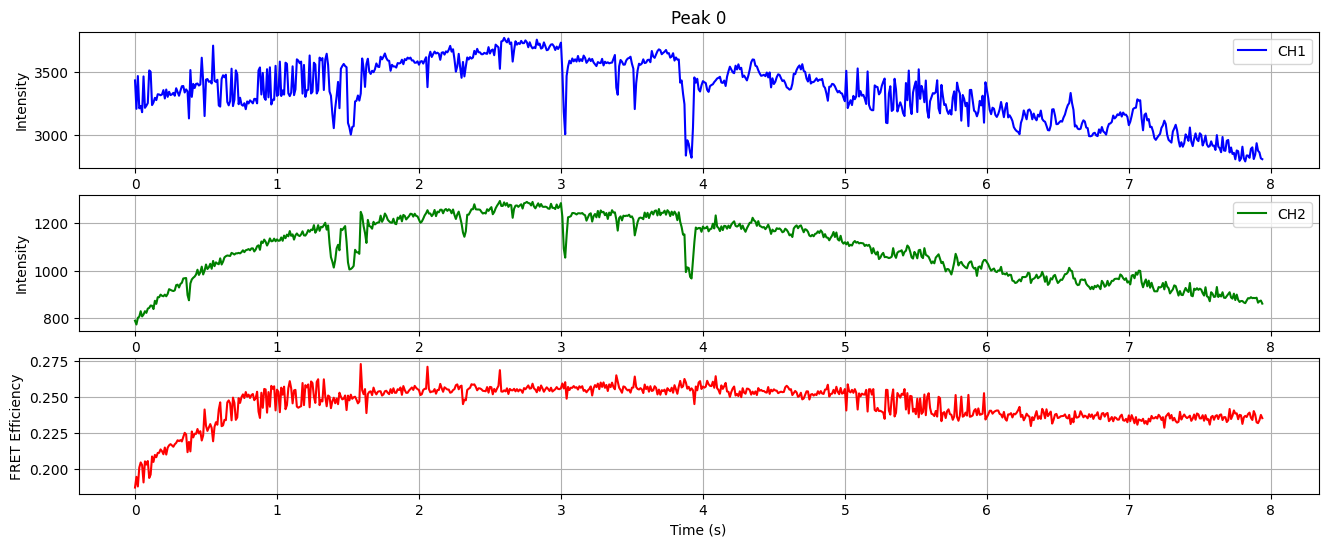

In [8]:
#space out the plots more
fig.subplots_adjust(hspace=1)
fig, ax = plt.subplots(3, 1, figsize=(16, 6))

ax[0].plot(time, tot_intensity_all_frames_CH1, color='b', label='CH1')
ax[0].set_title('Peak 0')
ax[0].set_ylabel('Intensity')
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].plot(time, tot_intensity_all_frames_CH2, color='g', label='CH2')
ax[1].set_ylabel('Intensity')
ax[1].grid()
ax[1].legend(loc='upper right')

ax[2].plot(time, FRET_values, color='r')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('FRET Efficiency')
ax[2].grid()

In [9]:
# def calc_distance(FRET_list, R_0):
#     d = R_0 * ((1/np.array(FRET_list)) - 1)**(1/6)
#     return d.tolist()

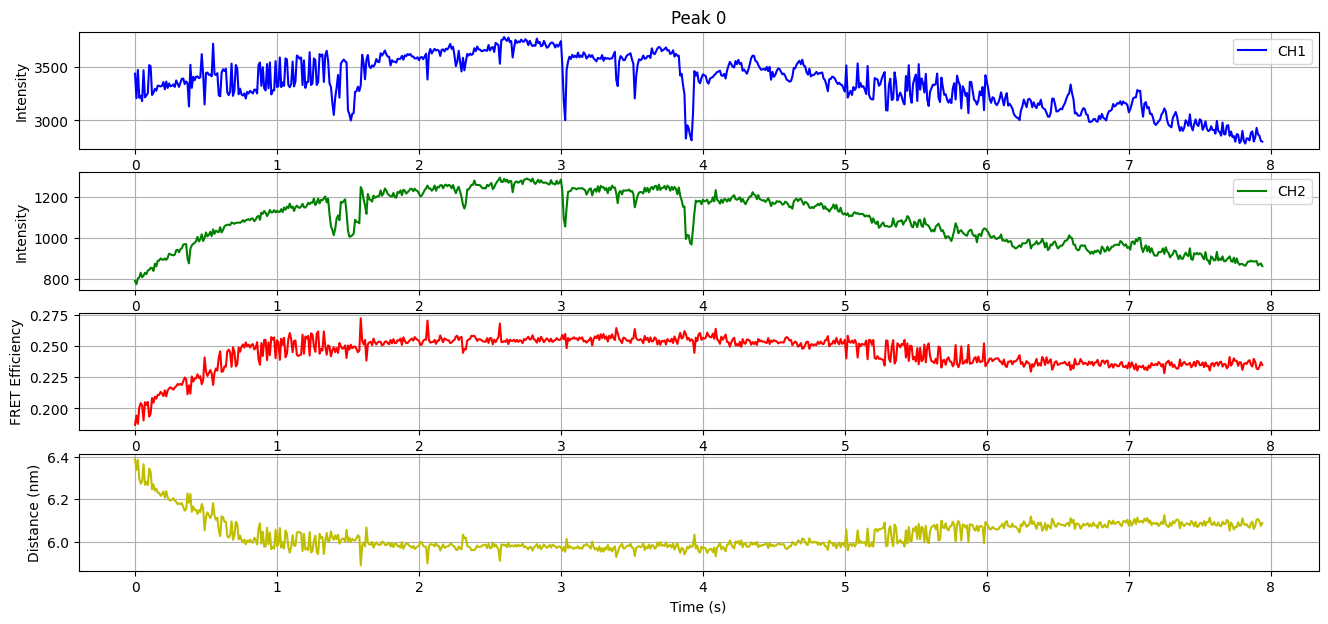

In [10]:
fig.subplots_adjust(hspace=1)
fig, ax = plt.subplots(4, 1, figsize=(16, 7))

ax[0].plot(time, tot_intensity_all_frames_CH1, color='b', label='CH1')
ax[0].set_title('Peak 0')
ax[0].set_ylabel('Intensity')
ax[0].legend(loc='upper right')
ax[0].grid()

ax[1].plot(time, tot_intensity_all_frames_CH2, color='g', label='CH2')
ax[1].set_ylabel('Intensity')
ax[1].legend(loc='upper right')
ax[1].grid()

ax[2].plot(time, FRET_values, color='r')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('FRET Efficiency')
ax[2].grid()
distance = calc_distance(FRET_values, 5.0)
ax[3].plot(time, distance, color='y')
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Distance (nm)')
ax[3].grid()
plt.show()


Image Size: 512 x 512


/Users/mac/Desktop/smImaging-Exploration/All Frames using avg/../pma_open.py:799: RuntimeWarning: overflow encountered in scalar subtract
  if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:


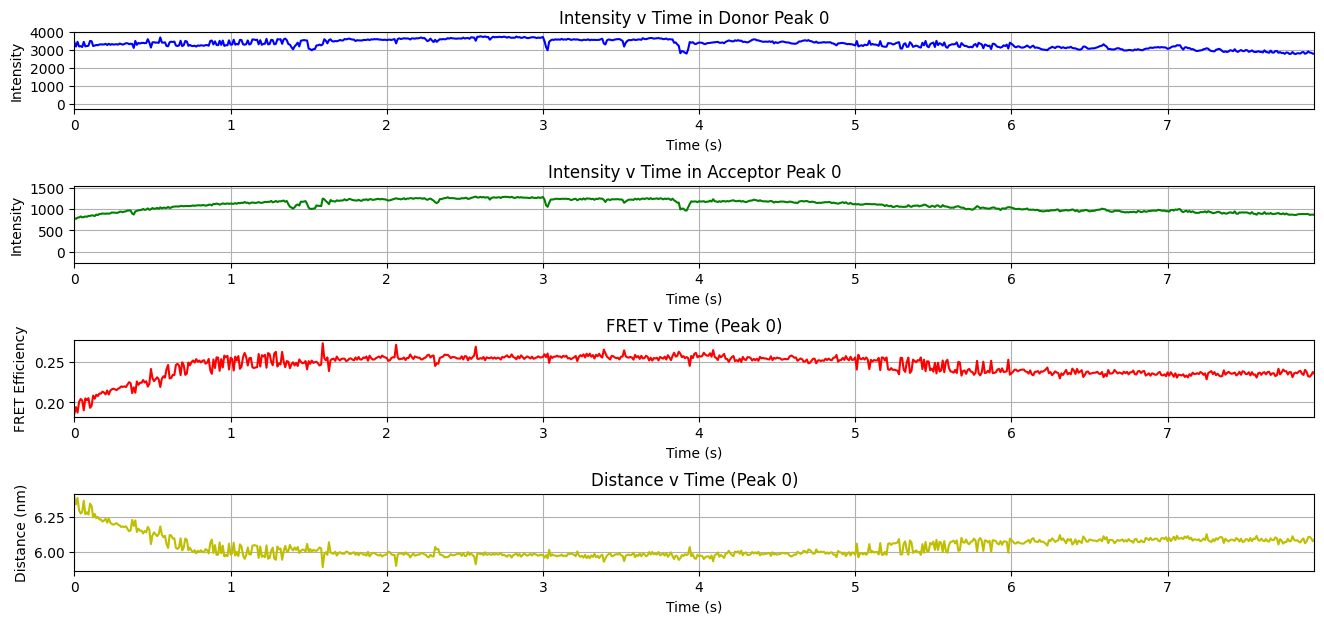

In [12]:
display_time_series(file_path, image, 0, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10, tpf = 1/100, R_0=5, radius=4, time_interval=1, background_treatment = "None", CH_consideration=False,  CH1_intensity_interval=1000, CH2_intensity_interval=500, figsize=(16,7))
